
### Papsmear SCAN MODEL


---

Imports 

---


In [1]:
import importlib
import pipeline as pl
importlib.reload(pl)
import model as ml
importlib.reload(ml)

import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import keras_tuner
from kerastuner.tuners import Hyperband

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.19.0


C:\Users\ckell\AppData\Local\Temp\ipykernel_26664\1512335882.py:22: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import Hyperband


---

Load Augmented data from pipeline

---

In [3]:
csv_path = "Pap Smear.csv"
train, test,val = pl.loadprocesseddata(csv_path)

Found 18750 validated image filenames belonging to 5 classes.
Found 3125 validated image filenames belonging to 5 classes.
Found 3125 validated image filenames belonging to 5 classes.


---

Build Model

---

In [4]:
def build_cnn_model(hp, n_classes=5):
    activation = hp.Choice("activation", values=["relu", "tanh", "elu"])
    n_conv_layers = hp.Int("n_conv_layers", min_value=2, max_value=5, step=1)
    n_filters = hp.Int("n_filters", min_value=8, max_value=64, step=8)
    
    kernel_size_val = hp.Choice("kernel_size", values=[3, 5])
    pool_size_val = hp.Choice("pool_size", values=[2, 3])
    
    learning_rate = hp.Float("learning_rate", min_value=1e-5, max_value=1e-2, sampling="log")
    decay_steps = hp.Int("decay_steps", min_value=1000, max_value=10000, step=1000)
    decay_rate = hp.Float("decay_rate", min_value=0.9, max_value=0.999, step=0.001)
    dropout_rate = hp.Float("dropout_rate", min_value=0.2, max_value=0.5, step=0.1)
    batch_norm = hp.Choice("batch_norm", values=[True, False])
    optimizer_choice = hp.Choice("optimizer", values=["sgd", "RMSprop", "adam", "AdamW"])
    
    expon_dec = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=learning_rate,
        decay_steps=decay_steps,
        decay_rate=decay_rate
    )
    if optimizer_choice == "sgd":
        optimizer = keras.optimizers.SGD(learning_rate=expon_dec)
    elif optimizer_choice == "RMSprop":
        optimizer = keras.optimizers.RMSprop(learning_rate=expon_dec)
    else:
        optimizer = keras.optimizers.Adam(learning_rate=expon_dec)
    
    model = keras.Sequential()
    
    model.add(layers.Conv2D(
        filters=n_filters,
        kernel_size=(kernel_size_val, kernel_size_val),
        activation=activation,
        input_shape=(64, 64, 3),
        padding='same'
    ))
    if batch_norm:
        model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(pool_size_val, pool_size_val)))
    
    for i in range(n_conv_layers - 1):
        model.add(layers.Conv2D(
            filters=n_filters * (2**i),
            kernel_size=(kernel_size_val, kernel_size_val),
            activation=activation,
            padding='same'
        ))
        if batch_norm:
            model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(pool_size=(pool_size_val, pool_size_val)))
        model.add(layers.Dropout(dropout_rate))

    model.add(layers.GlobalAveragePooling2D())
    
    n_dense_units = hp.Int("n_dense_units", min_value=32, max_value=256, step=32)
    model.add(layers.Dense(units=n_dense_units, activation=activation))
    if batch_norm:
        model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout_rate))
    
    model.add(layers.Dense(n_classes, activation="softmax"))
    
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    
    return model


---

Hyperband Search

---

In [6]:
tuner = Hyperband(
    lambda hp: build_cnn_model(hp),
    objective='val_accuracy',
    max_epochs=15,
    factor=3,
    directory='hyperbanding-ScanTypes',
    project_name='Pap')

c:\Users\ckell\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
tuner.search(train, epochs=10, validation_data=val)

Trial 22 Complete [00h 28m 43s]
val_accuracy: 0.9705600142478943

Best val_accuracy So Far: 0.9705600142478943
Total elapsed time: 02h 25m 51s


In [14]:
best_model = tuner.get_best_models(num_models=1)[0]

c:\Users\ckell\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\ckell\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 1 variables whereas the saved optimizer has 53 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


---

Train Best Model

---

In [15]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    restore_best_weights=True)

In [16]:
history = best_model.fit(
    train,
    epochs=200,
    validation_data=val,
    callbacks=[early_stopping])

Epoch 1/200
586/586 ━━━━━━━━━━━━━━━━━━━━ 295s 493ms/step - accuracy: 0.9667 - loss: 0.0969 - val_accuracy: 0.9405 - val_loss: 0.1688
Epoch 2/200
586/586 ━━━━━━━━━━━━━━━━━━━━ 108s 184ms/step - accuracy: 0.9715 - loss: 0.0863 - val_accuracy: 0.9210 - val_loss: 0.2320
Epoch 3/200
586/586 ━━━━━━━━━━━━━━━━━━━━ 109s 185ms/step - accuracy: 0.9719 - loss: 0.0856 - val_accuracy: 0.9533 - val_loss: 0.1163
Epoch 4/200
586/586 ━━━━━━━━━━━━━━━━━━━━ 109s 184ms/step - accuracy: 0.9757 - loss: 0.0758 - val_accuracy: 0.9462 - val_loss: 0.1549
Epoch 5/200
586/586 ━━━━━━━━━━━━━━━━━━━━ 109s 185ms/step - accuracy: 0.9743 - loss: 0.0774 - val_accuracy: 0.9306 - val_loss: 0.1960
Epoch 6/200
586/586 ━━━━━━━━━━━━━━━━━━━━ 108s 183ms/step - accuracy: 0.9771 - loss: 0.0651 - val_accuracy: 0.8829 - val_loss: 0.3229
Epoch 7/200
586/586 ━━━━━━━━━━━━━━━━━━━━ 109s 185ms/step - accuracy: 0.9827 - loss: 0.0530 - val_accuracy: 0.9766 - val_loss: 0.0732
Epoch 8/200
586/586 ━━━━━━━━━━━━━━━━━━━━ 108s 184ms/step - accuracy: 

---

Plot Learning Curve

---

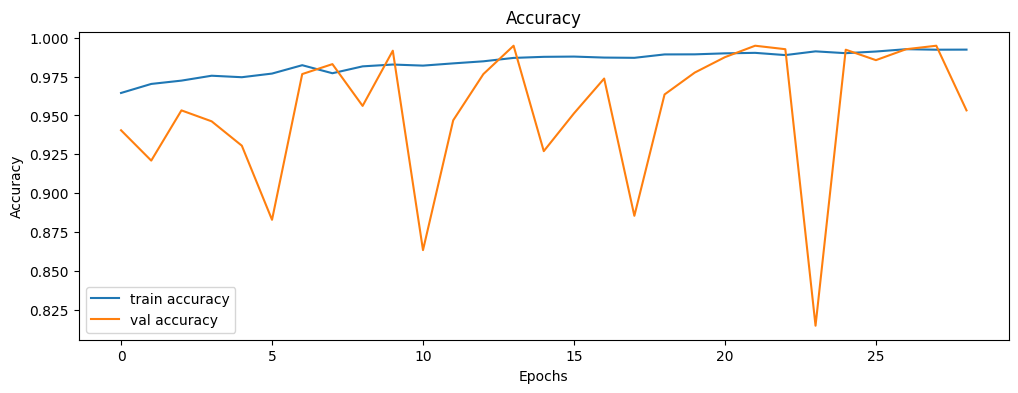

In [17]:
plt.figure(figsize=(12, 4))
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

---

Obtain model metrics

---

In [18]:
y_pred = best_model.predict(test, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = test.classes
results = classification_report(y_true, y_pred_classes)
print(results)


98/98 ━━━━━━━━━━━━━━━━━━━━ 31s 314ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       625
           1       0.99      1.00      0.99       625
           2       1.00      0.98      0.99       625
           3       0.99      1.00      1.00       625
           4       1.00      1.00      1.00       625

    accuracy                           0.99      3125
   macro avg       0.99      0.99      0.99      3125
weighted avg       0.99      0.99      0.99      3125



---

Obtain val Accuracy

---

In [ ]:
results = best_model.evaluate(val, verbose=1)
print(f"Metrics: {results[1:]}")

98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.9929 - loss: 0.0135
Metrics: [0.9942399859428406]


---

Save model

---


In [20]:
best_model.save('Pap Smear.keras')
